# Homework03 Flowers Recognition

# COMBINE WEEK08 WEEK04

According to week04 08 I'm looking for a way to classify a dataset that has good feature results and good learning ability.I have collated and improved data loading, model training, feature extraction, dimensionality reduction clustering and visualisation

## DATA:

This code implements a ``ResNet``-based image classification model, which is mainly used for the classification task of flower images.
Data source:https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/code?datasetId=8782

Method source:https://github.com/KaimingHe/deep-residual-networks


## Methods:
Model architecture: different variants of ResNet (e.g., ResNet34, ResNet50, etc.) are used, and these models solve the problem of gradient vanishing in deep networks through residual connectivity.

Data Enhancement: Data enhancement techniques such as random cropping and level-flipping were used to increase the diversity of training data and improve the generalisation ability of the model.

Optimiser: The model is trained using the Adam optimiser, which combines the advantages of momentum and adaptive learning rate to achieve fast convergence.

Feature extraction and clustering: the extracted features are downscaled using PCA and clustered using KMeans to visualise the feature distribution.
## OBJECTIVE:

Primary objective: to train a deep learning model capable of accurately classifying flower images.

Secondary objective: analyse the distribution of features learned by the model through feature extraction and clustering to further understand the model's behaviour.

## output:

Training output: training loss per epoch and accuracy on the validation set.

Model saving: save the best performing model on the validation set during training.

Feature visualisation: downscaling and clustering of features from training and validation sets by ``PCA`` and ``KMeans``, generating visual graphs.

Inference output: perform inference on a single image and output the predicted categories and their probabilities.

## Advantages

High performance: The ResNet architecture excels in image classification tasks and is able to handle gradient vanishing in deep networks.

Interpretability: Through feature extraction and clustering, it is possible to visualise the distribution of features learned by the model, helping to understand the model's behaviour.

Data Enhancement: Through data enhancement techniques, the diversity of training data is increased and the generalisation ability of the model is improved.

## Disadvantages

High computational resource requirements: the ResNet model is deeper and the training and inference process requires high computational resources, especially on large-scale datasets.

Risk of overfitting: Although data enhancement techniques are used, there is still a risk of overfitting on small datasets.

Feature visualisation limitations: although PCA downscaling and KMeans clustering can provide some visualisation, they may not fully reflect the complex structure of the high-dimensional feature space.

This code defines several different ResNet (Residual Network) architectures, implemented using PyTorch.ResNet is a deep convolutional neural network that solves the degeneracy problem in deep network training by introducing Residual Blocks.

In [ ]:
import torch.nn as nn
import torch

# Define the BasicBlock class, which is a basic residual block used in ResNet
class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor for the output channels

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        # First convolutional layer with 3x3 kernel, stride, and padding
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)  # Batch normalization layer
        self.relu = nn.ReLU()  # ReLU activation function
        # Second convolutional layer with 3x3 kernel, stride, and padding
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)  # Batch normalization layer
        self.downsample = downsample  # Downsample layer to match dimensions

    def forward(self, x):
        identity = x  # Save the input for the residual connection
        if self.downsample is not None:
            identity = self.downsample(x)  # Apply downsample if needed

        out = self.conv1(x)  # Apply first convolution
        out = self.bn1(out)  # Apply batch normalization
        out = self.relu(out)  # Apply ReLU activation

        out = self.conv2(out)  # Apply second convolution
        out = self.bn2(out)  # Apply batch normalization

        out += identity  # Add the input (identity) to the output (residual connection)
        out = self.relu(out)  # Apply ReLU activation

        return out  # Return the output

# Define the Bottleneck class, which is a more complex residual block used in deeper ResNet architectures
class Bottleneck(nn.Module):
    expansion = 4  # Expansion factor for the output channels

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups  # Calculate the width

        # First convolutional layer with 1x1 kernel to squeeze channels
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)  # Batch normalization layer
        # Second convolutional layer with 3x3 kernel, stride, and padding
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)  # Batch normalization layer
        # Third convolutional layer with 1x1 kernel to unsqueeze channels
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)  # Batch normalization layer
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function
        self.downsample = downsample  # Downsample layer to match dimensions

    def forward(self, x):
        identity = x  # Save the input for the residual connection
        if self.downsample is not None:
            identity = self.downsample(x)  # Apply downsample if needed

        out = self.conv1(x)  # Apply first convolution
        out = self.bn1(out)  # Apply batch normalization
        out = self.relu(out)  # Apply ReLU activation

        out = self.conv2(out)  # Apply second convolution
        out = self.bn2(out)  # Apply batch normalization
        out = self.relu(out)  # Apply ReLU activation

        out = self.conv3(out)  # Apply third convolution
        out = self.bn3(out)  # Apply batch normalization

        out += identity  # Add the input (identity) to the output (residual connection)
        out = self.relu(out)  # Apply ReLU activation

        return out  # Return the output

# Define the ResNet class, which constructs the ResNet architecture
class ResNet(nn.Module):

    def __init__(self,
                 block,  # Type of residual block (BasicBlock or Bottleneck)
                 blocks_num,  # Number of blocks in each layer
                 num_classes=1000,  # Number of output classes
                 include_top=True,  # Whether to include the top fully connected layer
                 groups=1,  # Number of groups for grouped convolution
                 width_per_group=64):  # Width per group for grouped convolution
        super(ResNet, self).__init__()
        self.include_top = include_top  # Whether to include the top fully connected layer
        self.in_channel = 64  # Initial number of channels

        self.groups = groups  # Number of groups for grouped convolution
        self.width_per_group = width_per_group  # Width per group for grouped convolution

        # Initial convolutional layer with 7x7 kernel, stride, and padding
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)  # Batch normalization layer
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Max pooling layer
        self.layer1 = self._make_layer(block, 64, blocks_num[0])  # First residual layer
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)  # Second residual layer
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)  # Third residual layer
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)  # Fourth residual layer
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive average pooling layer
            self.fc = nn.Linear(512 * block.expansion, num_classes)  # Fully connected layer

        # Initialize weights for convolutional layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        # If stride is not 1 or input channels do not match output channels, apply downsample
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        # Add the first residual block
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        # Add the remaining residual blocks
        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)  # Apply initial convolution
        x = self.bn1(x)  # Apply batch normalization
        x = self.relu(x)  # Apply ReLU activation
        x = self.maxpool(x)  # Apply max pooling

        x = self.layer1(x)  # Apply first residual layer
        x = self.layer2(x)  # Apply second residual layer
        x = self.layer3(x)  # Apply third residual layer
        x = self.layer4(x)  # Apply fourth residual layer

        if self.include_top:
            x = self.avgpool(x)  # Apply adaptive average pooling
            x = torch.flatten(x, 1)  # Flatten the output
            x = self.fc(x)  # Apply fully connected layer

        return x  # Return the output

# Function to create a ResNet-34 model
def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


Images of flowers were classified and the feature distribution of the data was explored by PCA downscaling and KMeans clustering analysis using a pre-trained ResNet34 model with its final fully-connected layer fine-tuned for a 5-class classification task.

using cuda:0 device.
Using 8 dataloader workers every process
using 3306 images for training, 364 images for validation.
valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.57it/s]
[epoch 1] train_loss: 0.506  val_accuracy: 0.885
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.38it/s]
[epoch 2] train_loss: 0.341  val_accuracy: 0.915
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.41it/s]
[epoch 3] train_loss: 0.299  val_accuracy: 0.898
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.30it/s]
[epoch 4] train_loss: 0.268  val_accuracy: 0.904
valid epoch[5/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.40it/s]
[epoch 5] train_loss: 0.242  val_accuracy: 0.918
valid epoch[6/30]: 100%|██████████

D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\envs\pytorch\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\anaconda3\envs\pytorch\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "D:\anaconda3\envs\pytorch\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "D:\anaconda3\envs\pytorch\lib\subprocess.py", line 858, in __init__
    se

Train features shape: (3306, 5)
Validation features shape: (364, 5)


D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


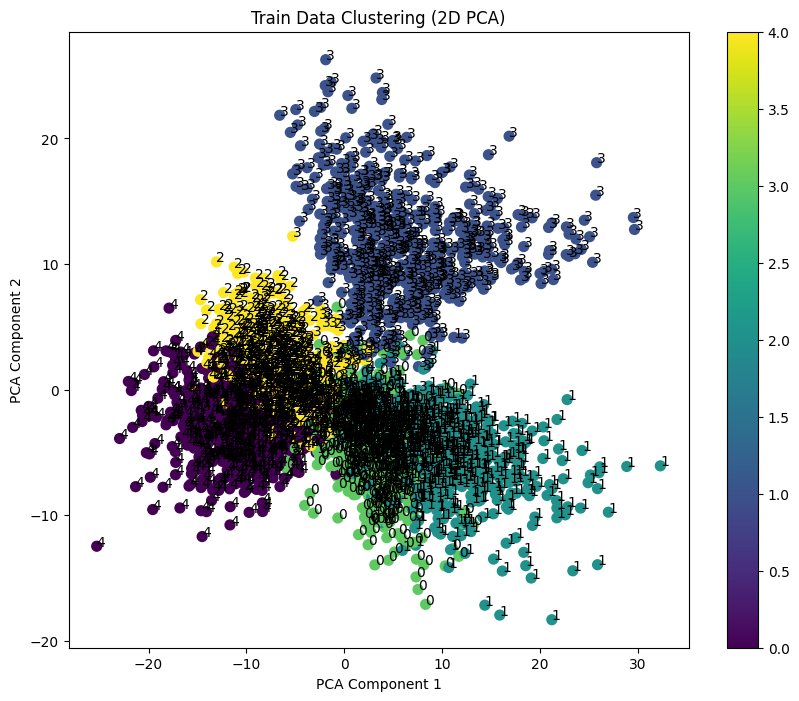

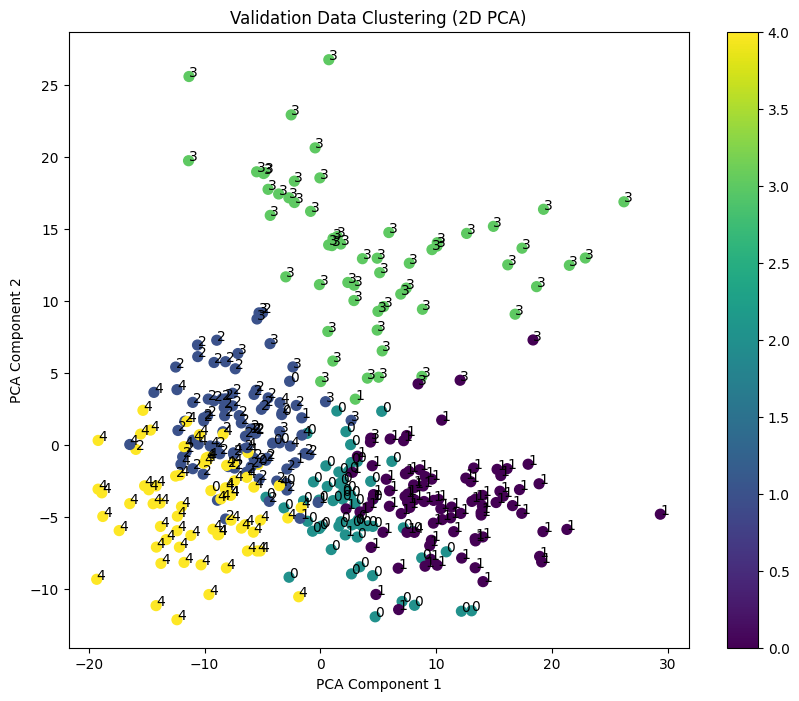

D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


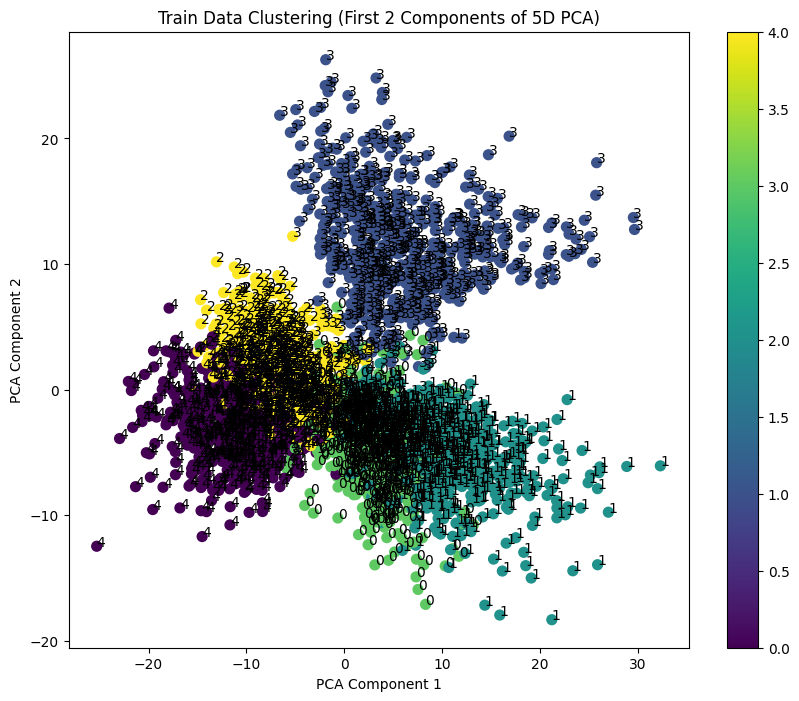

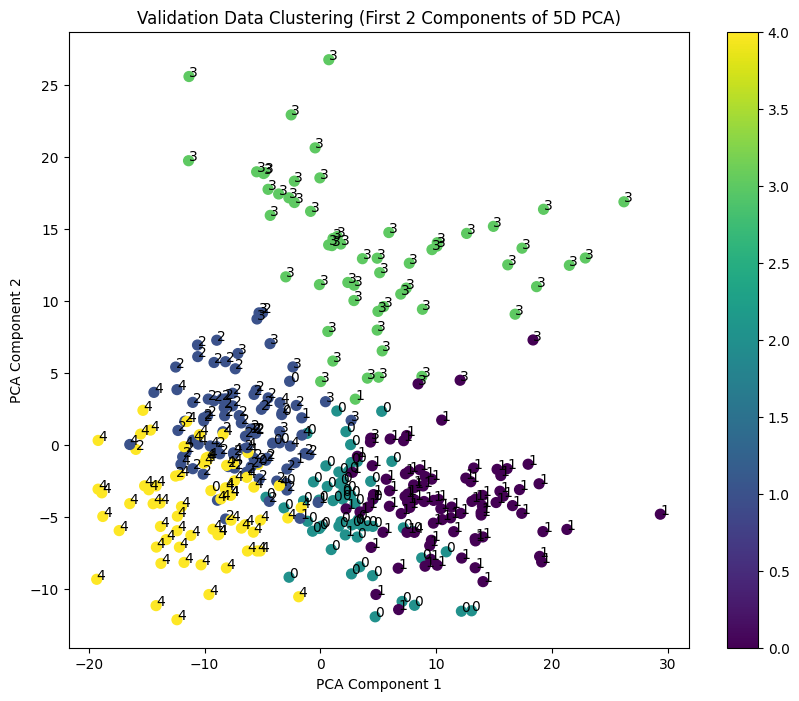

In [2]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    # data_root = os.path.abspath(os.path.join(os.getcwd(), "../"))  # get data root path
    data_root = r"E:\project\CV\Image_classification\resnet_flower"
    image_path = os.path.join(data_root, "data_set", "flower_data")  # flower data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    # {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
    flower_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in flower_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    net = resnet34()
    # load pretrain weights
    # download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
    model_weight_path = "./resnet34-333f7ec4.pth"
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
    net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
    # for param in net.parameters():
    #     param.requires_grad = False

    # change fc layer structure
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel, 5)
    net.to(device)

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.0001)

    epochs = 30
    best_acc = 0.0
    save_path = './flower.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits = net(images.to(device))
            loss = loss_function(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                # loss = loss_function(outputs, test_labels)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                           epochs)

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

    def extract_features(net, dataloader, device):
        net.eval()
        features = []
        labels = []
        with torch.no_grad():
            for data in dataloader:
                images, label = data
                images = images.to(device)
                output = net(images)
                features.append(output.cpu().numpy())
                labels.append(label.numpy())
        return np.concatenate(features), np.concatenate(labels)

    train_features, train_labels = extract_features(net, train_loader, device)
    val_features, val_labels = extract_features(net, validate_loader, device)

    def apply_pca_kmeans(features, n_components=2):
        pca = PCA(n_components=n_components)
        reduced_features = pca.fit_transform(features)
        kmeans = KMeans(n_clusters=5, random_state=42)
        clusters = kmeans.fit_predict(reduced_features)
        return reduced_features, clusters

    reduced_train_features, train_clusters = apply_pca_kmeans(train_features, n_components=2)
    reduced_val_features, val_clusters = apply_pca_kmeans(val_features, n_components=2)

    def plot_clusters(reduced_features, clusters, labels, title):
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50)
        plt.colorbar(scatter)
        plt.title(title)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        for i, txt in enumerate(labels):
            plt.annotate(txt, (reduced_features[i, 0], reduced_features[i, 1]))
        plt.show()

    print("Train features shape:", train_features.shape)
    print("Validation features shape:", val_features.shape)

    n_components = min(5, train_features.shape[1])  

    reduced_train_features, train_clusters = apply_pca_kmeans(train_features, n_components=n_components)
    reduced_val_features, val_clusters = apply_pca_kmeans(val_features, n_components=n_components)

    plot_clusters(reduced_train_features, train_clusters, train_labels, "Train Data Clustering (2D PCA)")
    plot_clusters(reduced_val_features, val_clusters, val_labels, "Validation Data Clustering (2D PCA)")

    reduced_train_features_5, train_clusters_5 = apply_pca_kmeans(train_features, n_components=5)
    reduced_val_features_5, val_clusters_5 = apply_pca_kmeans(val_features, n_components=5)

    plot_clusters(reduced_train_features_5[:, :2], train_clusters_5, train_labels,
                  "Train Data Clustering (First 2 Components of 5D PCA)")
    plot_clusters(reduced_val_features_5[:, :2], val_clusters_5, val_labels,
                  "Validation Data Clustering (First 2 Components of 5D PCA)")


if __name__ == '__main__':
    main()

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from model import resnet34


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    img_path = r"E:\project\CV\Image_classification\resnet_flower\data_set\flower_data\flower_photos\tulips\10791227_7168491604.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # create model
    model = resnet34(num_classes=5).to(device)

    # load model weights
    weights_path = "./flower.pth"
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location=device))

    # prediction
    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


if __name__ == '__main__':
    main()
